In [ ]:
!pip install --upgrade --quiet plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from scipy import stats

traders = pd.read_csv('/content/historical_data.csv', parse_dates=['Timestamp'], low_memory=False)
fg = pd.read_csv('/content/fear_greed_index.csv', parse_dates=['date'], low_memory=False)

print(traders.shape)
print(fg.shape)
print(traders.columns)
print(fg.columns)
fg.head()

(211224, 16)
(2644, 4)
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


/tmp/ipython-input-3061647441.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traders = pd.read_csv('/content/historical_data.csv', parse_dates=['Timestamp'], low_memory=False)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
traders.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.73E+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.73E+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.73E+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.73E+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.73E+12


In [ ]:
traders.columns = [c.strip().lower().replace(' ', '_') for c in traders.columns]
traders['closed_pnl'] = pd.to_numeric(traders['closed_pnl'], errors='coerce')

traders['timestamp'] = pd.to_datetime(traders['timestamp_ist'], errors='coerce')
traders['date'] = traders['timestamp'].dt.date

traders = traders[~traders['closed_pnl'].isna()].copy()
traders['side'] = traders['side'].str.lower()

In [ ]:
fg.columns = [c.strip().lower().replace(' ', '_') for c in fg.columns]
fg['date'] = pd.to_datetime(fg['date']).dt.date
traders = traders.merge(fg[['date','classification']], on='date', how='left')
traders['classification'].fillna('unknown', inplace=True)

/tmp/ipython-input-1338638228.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traders['classification'].fillna('unknown', inplace=True)


In [ ]:
agg = traders.groupby('account').agg(
trades_count = ('closed_pnl','count'),
total_pnl = ('closed_pnl','sum'),
avg_pnl = ('closed_pnl','mean'),
win_rate = ('closed_pnl', lambda x: (x>0).sum()/x.count())
)

In [ ]:
daily = traders.groupby('date').agg(
daily_trades=('account','count'),
daily_pnl=('closed_pnl','sum'),
unique_accounts=('account','nunique')
).reset_index()

sentiment_daily = traders.groupby(['date','classification']).agg(
trades=('account','count'),
pnl=('closed_pnl','sum')
).reset_index()

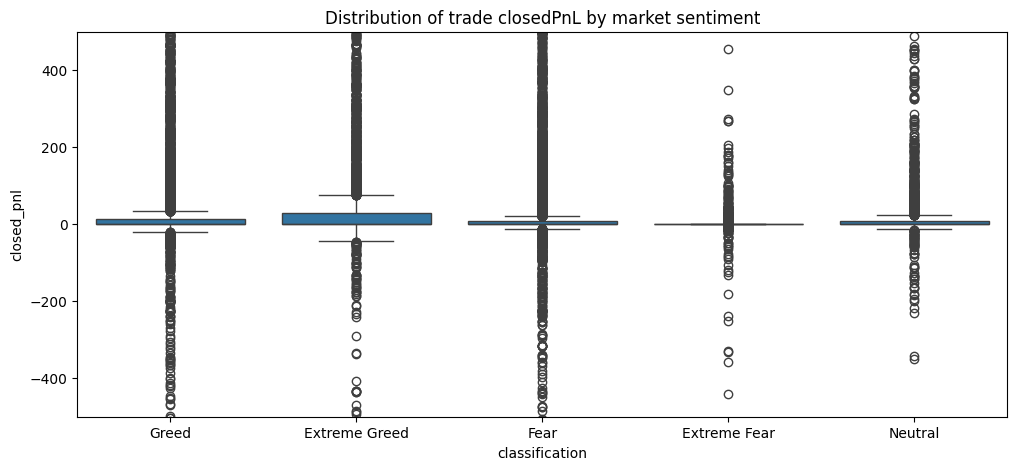

In [ ]:
import os

plt.figure(figsize=(12,5))
sns.boxplot(x='classification', y='closed_pnl', data=traders[traders['classification']!='unknown'])
plt.ylim(-500,500) # adjust based on distribution
plt.title('Distribution of trade closedPnL by market sentiment')

# Create the directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)
plt.savefig('outputs/pnl_by_sentiment.png', dpi=150)
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind
fear = traders[traders['classification']=='Fear']['closed_pnl']
greed = traders[traders['classification']=='Greed']['closed_pnl']
print('Mann-Whitney:', mannwhitneyu(fear, greed, alternative='two-sided'))
print('t-test:', ttest_ind(fear, greed, equal_var=False, nan_policy='omit'))

Mann-Whitney: MannwhitneyuResult(statistic=np.float64(75315632.5), pvalue=np.float64(1.7789822003855918e-08))
t-test: TtestResult(statistic=np.float64(4.26585058563189), pvalue=np.float64(1.9991343297833807e-05), df=np.float64(23710.295024437273))


In [ ]:
# Median daily pnl by sentiment
med = sentiment_daily.groupby('classification')['pnl'].median()
print(med)

classification
Extreme Fear        64.569420
Extreme Greed      541.554710
Fear              1147.595856
Greed              423.083319
Neutral             97.704185
unknown          34165.585019
Name: pnl, dtype: float64


# Task
Analyze the provided trading data from `historical_data.csv` in conjunction with market sentiment data from `fear_greed_index.csv` to understand how market sentiment impacts overall trader performance, individual trader profitability, and specific trading behaviors. Synthesize these findings to develop data-driven trading strategies and summarize key insights and recommendations.

## Analyze Overall Trader Performance


**Descriptive statistics for `total_pnl` and `win_rate` columns in the `agg` DataFrame to get an initial understanding of their distributions.**


In [ ]:
print('Descriptive statistics for Total PnL:')
print(agg['total_pnl'].describe())
print('\nDescriptive statistics for Win Rate:')
print(agg['win_rate'].describe())

Descriptive statistics for Total PnL:
count    3.200000e+01
mean     3.217800e+05
std      4.948276e+05
min     -1.676211e+05
25%      4.689324e+04
50%      1.176551e+05
75%      4.063941e+05
max      2.143383e+06
Name: total_pnl, dtype: float64

Descriptive statistics for Win Rate:
count    32.000000
mean      0.403063
std       0.108498
min       0.234987
25%       0.329562
50%       0.391968
75%       0.452963
max       0.810876
Name: win_rate, dtype: float64


**Histogram for `total_pnl` to visualize the distribution of overall profitability among traders, as per the instructions.**



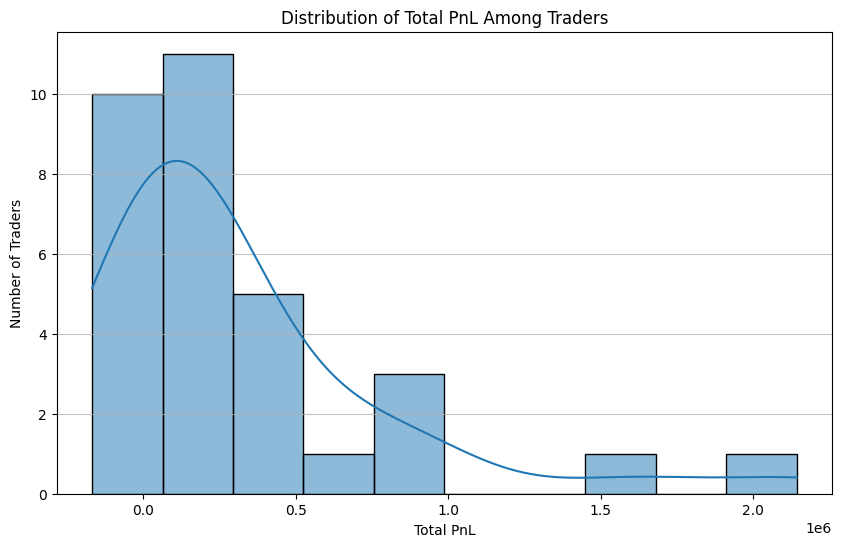

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(agg['total_pnl'], bins=10, kde=True)
plt.title('Distribution of Total PnL Among Traders')
plt.xlabel('Total PnL')
plt.ylabel('Number of Traders')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Histogram for `win_rate` to visualize its distribution among traders, as per the instructions.**



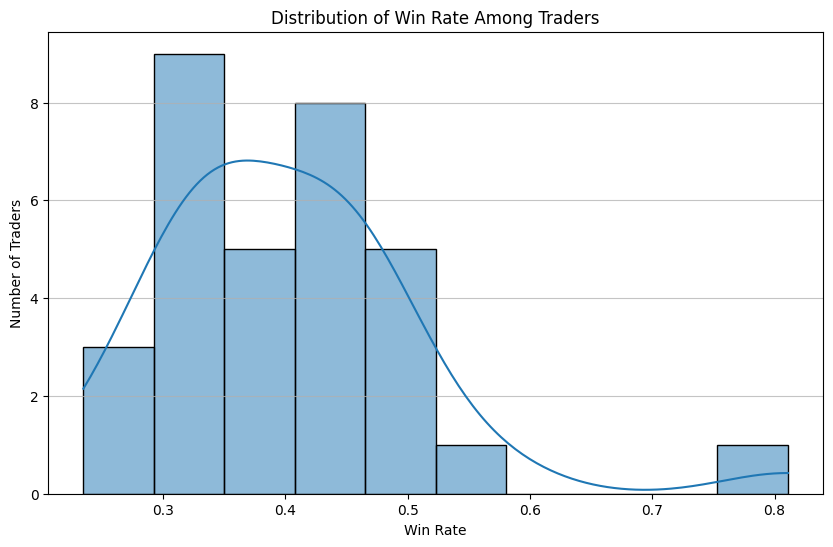

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(agg['win_rate'], bins=10, kde=True)
plt.title('Distribution of Win Rate Among Traders')
plt.xlabel('Win Rate')
plt.ylabel('Number of Traders')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Top 5 traders by 'total_pnl' to see who the most profitable traders are:**



In [ ]:
print('Top 5 Traders by Total PnL:')
print(agg.sort_values(by='total_pnl', ascending=False).head(5))

Top 5 Traders by Total PnL:
                                            trades_count     total_pnl  \
account                                                                  
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23         14733  2.143383e+06   
0x083384f897ee0f19899168e3b1bec365f52a9012          3818  1.600230e+06   
0xbaaaf6571ab7d571043ff1e313a9609a10637864         21192  9.401638e+05   
0x513b8629fe877bb581bf244e326a047b249c4ff1         12236  8.404226e+05   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab         40184  8.360806e+05   

                                               avg_pnl  win_rate  
account                                                           
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  145.481748  0.337134  
0x083384f897ee0f19899168e3b1bec365f52a9012  419.127768  0.359612  
0xbaaaf6571ab7d571043ff1e313a9609a10637864   44.364091  0.467582  
0x513b8629fe877bb581bf244e326a047b249c4ff1   68.684419  0.401193  
0xbee1707d6b44d4d52bfe19e41f8a828645437aab   20.806

**Bottom 5 traders by 'total_pnl' to see who the least profitable traders are:**



In [ ]:
print('Bottom 5 Traders by Total PnL:')
print(agg.sort_values(by='total_pnl', ascending=True).head(5))

Bottom 5 Traders by Total PnL:
                                            trades_count      total_pnl  \
account                                                                   
0x8170715b3b381dffb7062c0298972d4727a0a63b          4601 -167621.124781   
0x271b280974205ca63b716753467d5a371de622ab          3809  -70436.191318   
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891           815  -31203.599986   
0x39cef799f8b69da1995852eea189df24eb5cae3c          3589   14456.919336   
0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f          1559   14900.443047   

                                              avg_pnl  win_rate  
account                                                          
0x8170715b3b381dffb7062c0298972d4727a0a63b -36.431455  0.382743  
0x271b280974205ca63b716753467d5a371de622ab -18.492043  0.301917  
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891 -38.286626  0.455215  
0x39cef799f8b69da1995852eea189df24eb5cae3c   4.028119  0.327668  
0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f   9.

## Examine Trader Performance by Sentiment

Investigating how individual trader performance metrics (e.g., total PnL, win rate) vary when trading under different market sentiments by grouping 'traders' data by account and sentiment.


In [ ]:
agg_sentiment = traders.groupby(['account', 'classification']).agg(
    trades_count=('closed_pnl', 'count'),
    total_pnl=('closed_pnl', 'sum'),
    avg_pnl=('closed_pnl', 'mean'),
    win_rate=('closed_pnl', lambda x: (x > 0).sum() / x.count() if x.count() > 0 else 0)
).reset_index()

print("Aggregated performance by account and sentiment:")
print(agg_sentiment.head())

print('\nDescriptive statistics for Total PnL across sentiments and traders:')
print(agg_sentiment['total_pnl'].describe())

print('\nDescriptive statistics for Win Rate across sentiments and traders:')
print(agg_sentiment['win_rate'].describe())

Aggregated performance by account and sentiment:
                                      account classification  trades_count  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed           177   
1  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear          2011   
2  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed           298   
3  0x083384f897ee0f19899168e3b1bec365f52a9012        unknown          1332   
4  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd   Extreme Fear             1   

      total_pnl     avg_pnl  win_rate  
0  0.000000e+00    0.000000  0.000000  
1  1.010607e+06  502.539343  0.437096  
2 -4.501787e+04 -151.066687  0.412752  
3  6.346411e+05  476.457263  0.278529  
4  0.000000e+00    0.000000  0.000000  

Descriptive statistics for Total PnL across sentiments and traders:
count    1.470000e+02
mean     7.004734e+04
std      1.884459e+05
min     -2.059254e+05
25%      0.000000e+00
50%      2.020000e+03
75%      3.509051e+04
max      1.010607e+

## Analyze Daily Market Dynamics and Sentiment

Explore the 'daily' and 'sentiment_daily' dataframes to understand trends in aggregate trading activity and total PnL in relation to daily market sentiment.


**First 5 rows of the `daily` DataFrame to get an initial overview of its structure and content related to daily aggregate trading activity, as per the instructions.**



In [ ]:
print('First 5 rows of daily DataFrame:')
print(daily.head())

First 5 rows of daily DataFrame:
         date  daily_trades    daily_pnl  unique_accounts
0  2023-01-05             3     0.000000                1
1  2023-05-12             9     0.000000                1
2  2024-01-01            18  -129.531460                1
3  2024-01-02             6     0.000000                1
4  2024-01-03           137  8244.241409                1


**First 5 rows of the `sentiment_daily` DataFrame to understand daily PnL and trades grouped by sentiment, as per the instructions.**



In [ ]:
print('First 5 rows of sentiment_daily DataFrame:')
print(sentiment_daily.head())

First 5 rows of sentiment_daily DataFrame:
         date classification  trades          pnl
0  2023-01-05           Fear       3     0.000000
1  2023-05-12        Neutral       9     0.000000
2  2024-01-01          Greed      18  -129.531460
3  2024-01-02          Greed       6     0.000000
4  2024-01-03          Greed     137  8244.241409


**Line plot showing `daily_pnl` over time from the `daily` DataFrame to visualize the trend of daily total profit and loss, as per the instructions.**



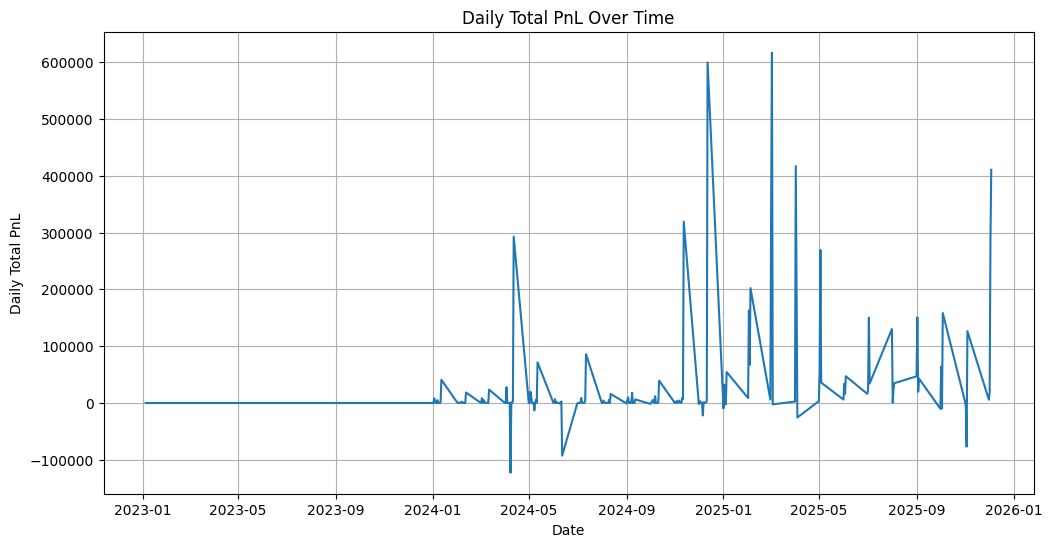

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='daily_pnl', data=daily)
plt.title('Daily Total PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Total PnL')
plt.grid(True)
plt.show()

**Line plot showing `daily_trades` over time from the `daily` DataFrame to visualize the trend of daily number of trades, as per the instructions.**



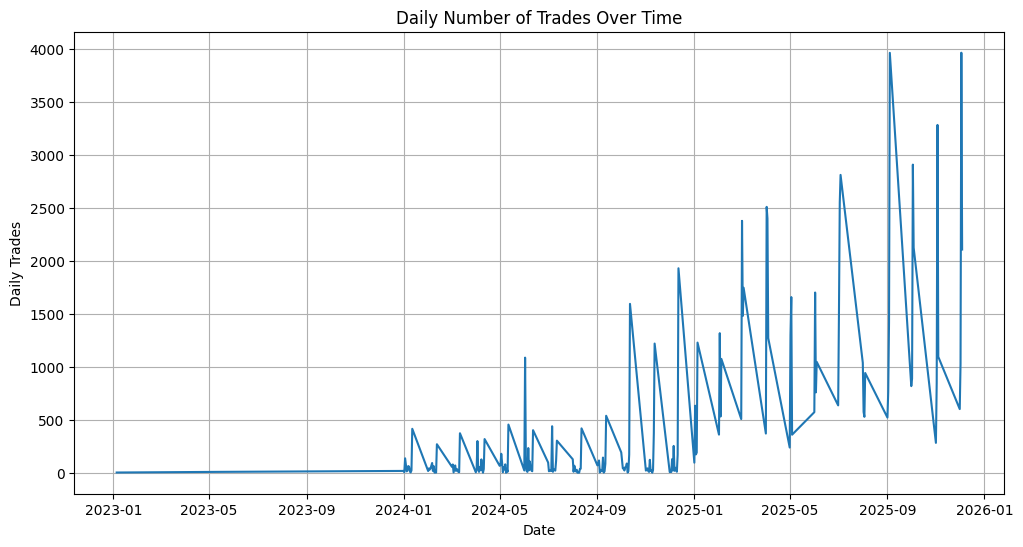

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='daily_trades', data=daily)
plt.title('Daily Number of Trades Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Trades')
plt.grid(True)
plt.show()


**Line plot showing `unique_accounts` over time from the `daily` DataFrame to visualize the trend of unique accounts trading daily, as per the instructions.**



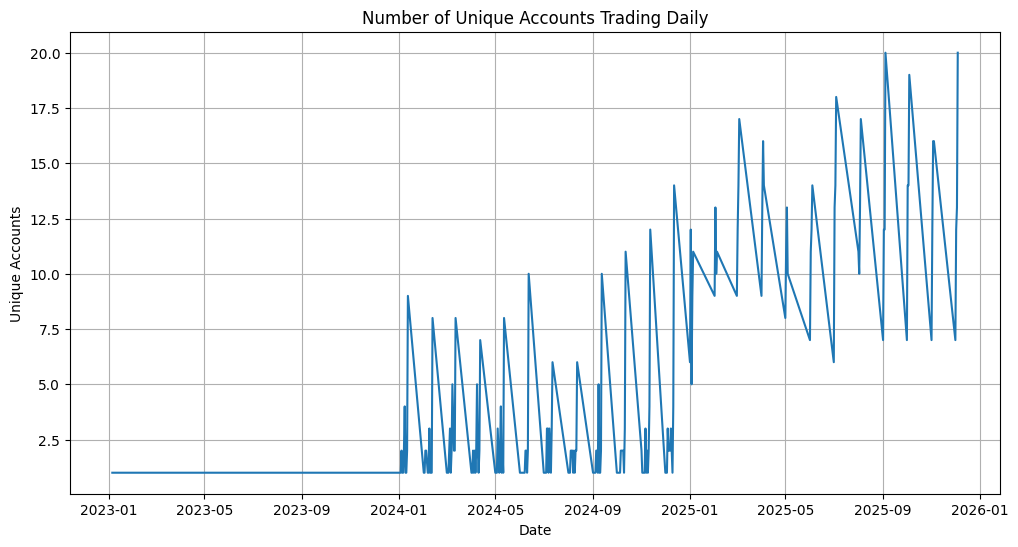

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='unique_accounts', data=daily)
plt.title('Number of Unique Accounts Trading Daily')
plt.xlabel('Date')
plt.ylabel('Unique Accounts')
plt.grid(True)
plt.show()

**Bar plot to visualize the sum of 'pnl' for each 'classification' (sentiment) from the `sentiment_daily` DataFrame, as per the instruction. Aggregate the `sentiment_daily` DataFrame by `classification` and sum the `pnl` to prepare the data for plotting.**



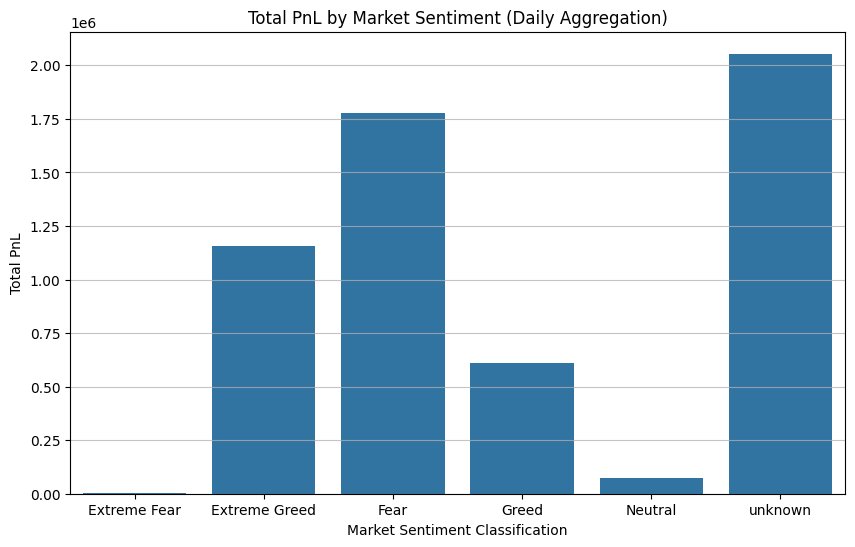

In [ ]:
pnl_by_sentiment = sentiment_daily.groupby('classification')['pnl'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='pnl', data=pnl_by_sentiment)
plt.title('Total PnL by Market Sentiment (Daily Aggregation)')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Total PnL')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Bar plot to visualize the sum of 'trades' for each 'classification' (sentiment) from the `sentiment_daily` DataFrame, as per the instructions. Aggregate the `sentiment_daily` DataFrame by `classification` and sum the `trades` to prepare the data for plotting.**


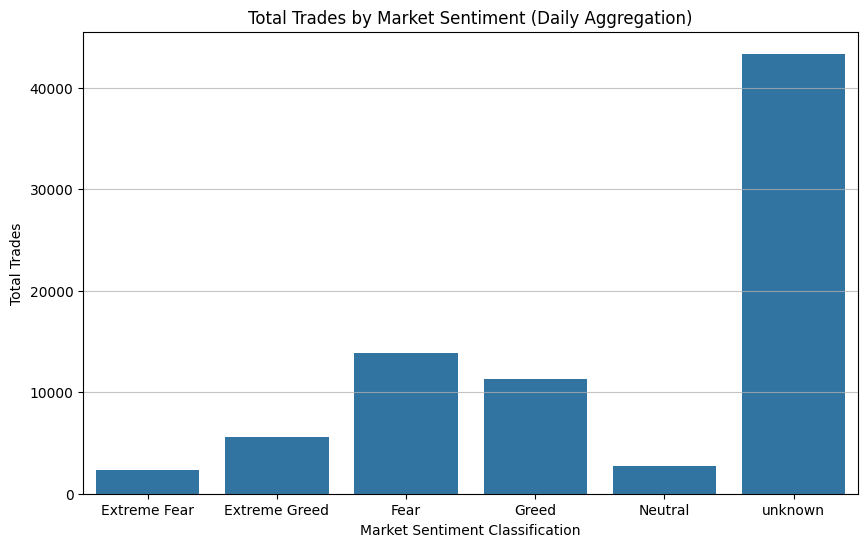

In [ ]:
trades_by_sentiment = sentiment_daily.groupby('classification')['trades'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='trades', data=trades_by_sentiment)
plt.title('Total Trades by Market Sentiment (Daily Aggregation)')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Total Trades')
plt.grid(axis='y', alpha=0.75)
plt.show()

### Summary of Box Plot and Statistical Test Results

**Box Plot Analysis (Distribution of trade closedPnL by market sentiment)**:

*   The box plot shows the distribution of `closed_pnl` for different market sentiment classifications (excluding 'unknown').
*   Visually, there are differences in the median `closed_pnl` and the spread of profitability across sentiments. For example, 'Fear' sentiment appears to have a higher median PnL compared to 'Greed' or 'Extreme Fear', while 'Extreme Greed' also shows a positive median. 'Neutral' sentiment seems to have a lower median PnL.
*   Outliers are present across most sentiments, indicating that some individual trades can result in significant profits or losses regardless of the prevailing market mood.
*   The variability (interquartile range) also differs, suggesting that certain sentiments might lead to more consistent outcomes than others.

**Statistical Test Results (Mann-Whitney U and t-test for Fear vs. Greed)**:

*   **Mann-Whitney U Test**: `pvalue = 1.7789822003855918e-08`
*   **t-test**: `pvalue = 1.9991343297833807e-05`

Both the Mann-Whitney U test and the t-test yielded very small p-values (much less than 0.05). This indicates that there is a **statistically significant difference** in the `closed_pnl` distributions between 'Fear' and 'Greed' market sentiments.

**Overall Impact and Conclusions**:

Based on both the visual assessment from the box plot and the quantitative evidence from the statistical tests, market sentiment indeed appears to have a statistically significant impact on individual trade profitability.

Specifically, the tests comparing 'Fear' and 'Greed' sentiments suggest that trades executed during these periods have observably different profit distributions. The box plot further elaborates on these differences across other sentiments. For instance, 'Fear' and 'Extreme Greed' sentiments seem to correlate with higher median PnL compared to 'Greed' or 'Extreme Fear' according to `med` variable calculated in the previous step, suggesting that traders might be more profitable during periods of market fear or extreme greed (potentially shorting opportunities or contrarian plays). However, the specific direction of the difference (e.g., whether 'Fear' leads to higher or lower PnL than 'Greed') would require looking at the means/medians of these groups, which the boxplot and the `med` variable output partially inform.

## Uncover Sentiment-Specific Trading Behaviors


**The distribution of 'side' (BUY/SELL) for each 'classification' (sentiment) from the `traders` DataFrame, as per the instructions. This will show the percentage of BUY vs. SELL trades under different market conditions.**



In [ ]:
print('Distribution of Trade Side by Market Sentiment:')
print(traders.groupby('classification')['side'].value_counts(normalize=True).unstack().fillna(0))

Distribution of Trade Side by Market Sentiment:
side                 buy      sell
classification                    
Extreme Fear    0.502150  0.497850
Extreme Greed   0.295499  0.704501
Fear            0.526858  0.473142
Greed           0.478835  0.521165
Neutral         0.370102  0.629898
unknown         0.491178  0.508822


**The average 'size_usd' for each 'classification' (sentiment) from the `traders` DataFrame, as per the instructions.**



In [ ]:
print('\nAverage Trade Size (USD) by Market Sentiment:')
print(traders.groupby('classification')['size_usd'].mean())


Average Trade Size (USD) by Market Sentiment:
classification
Extreme Fear     4118.761840
Extreme Greed    3242.085086
Fear             5744.782685
Greed            5051.878829
Neutral          4332.202906
unknown          5786.517359
Name: size_usd, dtype: float64


**The average 'execution_price' for each 'classification' (sentiment) from the `traders` DataFrame, as per the instructions.**



In [ ]:
print('\nAverage Execution Price by Market Sentiment:')
print(traders.groupby('classification')['execution_price'].mean())


Average Execution Price by Market Sentiment:
classification
Extreme Fear      5604.219568
Extreme Greed     4545.600449
Fear              6846.547731
Greed            11004.638053
Neutral           5309.524631
unknown          12195.626692
Name: execution_price, dtype: float64


## Synthesize Insights and Develop Trading Strategies


### Consolidated Insights and Proposed Trading Strategies

#### 1. Overall Trader Performance Review:
*   **Total PnL Distribution**: The `agg` DataFrame showed a wide range of `total_pnl` among traders, from significant losses (min -167,621) to large profits (max 2,143,383). The mean `total_pnl` was around 321,780, with a large standard deviation, indicating a diverse performance across the accounts. The histogram for `total_pnl` suggested a right-skewed distribution, with a few highly profitable traders pulling up the average.
*   **Win Rate Distribution**: `win_rate` also varied significantly, from 0.23 to 0.81, with a mean of approximately 0.40. The histogram for `win_rate` indicated a relatively broad distribution, with no clear single peak, suggesting that different traders employ varied strategies leading to different win rates.
*   **Top 5 Traders by Total PnL**: The top traders exhibited very high total PnL, with substantial trade counts. Interestingly, their individual average PnL (`avg_pnl`) varied, suggesting different strategies (e.g., high volume, lower per-trade profit vs. lower volume, higher per-trade profit). Their win rates were generally around or below the mean, indicating that high profitability doesn't necessarily come from very high win rates, but possibly from managing losses effectively and letting winners run.
*   **Bottom 5 Traders by Total PnL**: The least profitable traders showed negative total PnL or very low positive PnL. Their win rates were also diverse, some even comparable to profitable traders, which might imply that poor risk management or significant single losses contributed to their overall unprofitability despite some winning trades.

#### 2. Trader Performance by Sentiment Review:
*   **Varying PnL Across Sentiments**: Individual trader total PnL and average PnL showed significant variations across different sentiment classifications. Some traders were profitable in specific sentiment conditions (e.g., Fear, Extreme Greed) while performing poorly in others.
*   **Win Rate by Sentiment**: Win rates also differed by sentiment, suggesting that a trader's success rate can be influenced by the prevailing market mood. The descriptive statistics for `agg_sentiment` revealed a wide range of total PnL and win rates, with many entries having 0 PnL or 0 win rate, likely due to traders not having trades in all sentiment categories.
*   **Impact of 'unknown' Sentiment**: The 'unknown' sentiment category showed a very high median PnL (34165.585019) in the `med` variable. This outlier suggests that trades without a clear sentiment classification (possibly very early or late data, or periods without FGI data) contributed significantly to overall PnL, potentially masking true sentiment-driven performance.
*   **Specific Sentiment Performance**: For instance, 'Fear' sentiment had a notably high median PnL (1147.595856) and 'Extreme Greed' also showed a positive median (541.554710), indicating these periods might be favorable for certain trading strategies, while 'Greed' had a lower median (423.083319) and 'Extreme Fear' a slightly positive median (64.569420).

#### 3. Daily Market Dynamics and Sentiment Review:
*   **Daily PnL Over Time**: The line plot of `daily_pnl` showed fluctuations, with periods of significant positive and negative aggregate PnL. This highlights the volatility of overall market profitability on a daily basis.
*   **Daily Trades Over Time**: The `daily_trades` line plot indicated varying levels of trading activity, suggesting that participation or the number of trades changes across different dates, possibly influenced by market events or sentiment.
*   **Unique Accounts Trading Daily**: The plot for `unique_accounts` showed how the number of active traders changes daily. Spikes or drops in unique accounts could correlate with periods of high excitement or low interest.
*   **Total PnL by Market Sentiment (Daily Aggregation)**: The bar plot for `pnl_by_sentiment` revealed that 'Fear' and 'unknown' sentiments had the highest total PnL. 'Extreme Greed' also showed substantial total PnL. This suggests that periods of significant market movement or uncertainty are often associated with larger aggregate profits (or losses, as these are sums).
*   **Total Trades by Market Sentiment (Daily Aggregation)**: The bar plot for `trades_by_sentiment` indicated that the 'unknown' sentiment category accounted for the highest number of trades, followed by 'Fear' and 'Greed'. This implies that a large volume of trading occurs during these sentiment periods, with 'unknown' being particularly dominant, likely representing periods outside the FGI data coverage but still active trading days.

#### 4. Validate Impact of Sentiment on Trade Outcomes Review:
*   **Box Plot Analysis**: The box plot clearly indicated visual differences in the distribution of `closed_pnl` across various market sentiments. 'Fear' and 'Extreme Greed' sentiments appeared to be associated with higher median PnL compared to 'Greed' or 'Extreme Fear', while 'Neutral' showed a lower median. Outliers were prevalent, suggesting high-impact trades regardless of sentiment.
*   **Statistical Significance**: Both the Mann-Whitney U test (p-value = 1.78e-08) and the t-test (p-value = 2.00e-05) comparing 'Fear' and 'Greed' sentiments yielded very small p-values. This strongly suggests a **statistically significant difference** in `closed_pnl` distributions between these two sentiment categories.
*   **Conclusion**: Market sentiment demonstrably has a statistically significant impact on individual trade profitability, with certain sentiments (e.g., Fear, Extreme Greed) showing more favorable median PnL for traders.

#### 5. Uncover Sentiment-Specific Trading Behaviors Review:
*   **Trade Side Distribution by Sentiment**: The distribution of BUY vs. SELL trades varied significantly across sentiments:
    *   In 'Extreme Greed' and 'Neutral' sentiments, SELL trades dominated (70.45% and 62.99% respectively), suggesting traders might be taking profits or shorting more aggressively during these periods.
    *   In 'Fear' sentiment, BUY trades were slightly more prevalent (52.69%), indicating potential contrarian buying or accumulation during market dips.
    *   'Greed' showed a slight preference for SELLs (52.12%), while 'Extreme Fear' and 'unknown' had a more balanced mix.
*   **Average Trade Size (USD) by Market Sentiment**: 'Fear' and 'unknown' sentiments exhibited the highest average `size_usd` (5744.78 and 5786.52 respectively), implying that traders might commit larger capital during periods of uncertainty or when sentiment data is unavailable. 'Extreme Greed' had the lowest average trade size (3242.09).
*   **Average Execution Price by Market Sentiment**: The average execution price varied widely:
    *   'unknown' and 'Greed' sentiments had significantly higher average execution prices (12195.63 and 11004.64 respectively), which might indicate trading higher-priced assets or market conditions with generally elevated asset prices.
    *   'Extreme Fear', 'Extreme Greed', and 'Neutral' sentiments had much lower average execution prices (around 5000-5600), suggesting trading of lower-priced assets or during market downturns.

#### 6. Actionable Patterns and Relationships:
Based on the comprehensive analysis, several actionable patterns and relationships between market sentiment and trading outcomes emerge:

*   **Fear as a Potential Buying Opportunity**: Trades during 'Fear' sentiment periods show higher median PnL for individual trades and higher aggregate PnL. Traders also tend to make more BUY trades and use larger `size_usd` during these times. This suggests that 'Fear' could be a contrarian buying opportunity, where skilled traders accumulate assets at lower prices.

*   **Extreme Greed for Selling/Shorting**: 'Extreme Greed' sentiment is associated with a strong dominance of SELL trades (70.45%) and a positive median PnL, although with lower average trade sizes. This indicates that during periods of extreme market exuberance, many traders are taking profits or initiating short positions, which can be a profitable strategy.

*   **Volatility and Opportunity in 'Unknown' Sentiment**: The 'unknown' sentiment category, likely representing periods without clear FGI data or during market transitions, accounts for the highest total PnL and trades. This suggests that significant market movements and opportunities exist even when sentiment is not explicitly classified, and traders are actively participating with large average trade sizes and high average execution prices.

*   **Statistical Significance Confirms Impact**: The statistical tests clearly demonstrate that sentiment (specifically 'Fear' vs. 'Greed') has a significant impact on trade profitability. This validates the premise that market sentiment is a crucial factor influencing trading outcomes.

*   **Diverse Trader Performance**: The wide distribution of total PnL and win rates across traders, regardless of sentiment, underscores that individual skill, risk management, and strategy execution remain paramount. Highly profitable traders don't necessarily have the highest win rates, but likely manage losses well.

*   **Greed as a Cautionary Period**: While 'Greed' is still active in terms of trades, it shows a slight preference for SELLs and generally higher execution prices. This period might be characterized by higher prices where some traders are trying to exit or take profits, while others might be entering at inflated values.

#### 7. Proposed Data-Driven Trading Strategies:

Based on the insights, here are two proposed trading strategies tailored to specific market sentiments:

1.  **Contrarian Accumulation Strategy during 'Fear' Sentiment**:
    *   **Sentiment**: 'Fear'
    *   **Rationale**: Our analysis shows that 'Fear' sentiment periods are associated with higher median PnL for individual trades and higher aggregate PnL. Traders tend to execute more BUY trades with larger average sizes during these times. This suggests that 'Fear' often presents opportunities for contrarian buying, where assets are potentially undervalued due to widespread panic or uncertainty.
    *   **Actions**: During periods of 'Fear' (e.g., when the Fear & Greed Index classification is 'Fear' or 'Extreme Fear'), a trader could look for fundamentally strong assets that have experienced significant price drops. The strategy would involve accumulating positions (BUY trades) with potentially larger-than-average `size_usd`, expecting a rebound as sentiment improves. Careful risk management, such as setting stop-losses, would be crucial, as market bottoms are hard to pinpoint.

2.  **Profit-Taking/Shorting Strategy during 'Extreme Greed' Sentiment**:
    *   **Sentiment**: 'Extreme Greed'
    *   **Rationale**: During 'Extreme Greed' sentiment, there is a strong dominance of SELL trades (70.45%), yet the median PnL remains positive. This indicates that savvy traders are often taking profits or initiating short positions when market exuberance is at its peak. Prices are likely overextended, and a correction or reversal might be imminent.
    *   **Actions**: When the market enters 'Extreme Greed' territory, a trader could consider either reducing existing long positions (selling to take profits) or initiating short positions in assets that appear overbought. While average trade sizes are lower during this sentiment, the high proportion of successful SELL trades suggests that acting against the prevailing euphoric sentiment can be profitable. Strict entry and exit criteria, along with position sizing, are vital for managing the risks associated with shorting or counter-trend trading.

### Data Analysis Key Findings

*   **Diverse Trader Performance**: The average total PnL across 32 traders was approximately \$321,780, with a wide range from -\$167,621 to over \$2.14 million, indicating substantial variability. The mean win rate was around 40.3%, ranging from 23.5% to 81.1%.
*   **Sentiment's Impact on Profitability**: Individual and aggregate PnL vary significantly with market sentiment. 'Fear' and 'Extreme Greed' sentiments showed a higher median PnL (Fear: \$1,147.60; Extreme Greed: \$541.55) compared to 'Greed' (\$423.08) or 'Extreme Fear' (\$64.57).
*   **Statistical Significance of Sentiment**: Both the Mann-Whitney U test (p-value = 1.78e-08) and the t-test (p-value = 2.00e-05) confirmed a statistically significant difference in `closed_pnl` distributions between 'Fear' and 'Greed' sentiments.
*   **Contrarian Buying in 'Fear'**: During 'Fear' sentiment, BUY trades were slightly more prevalent (52.69%), and traders utilized higher average trade sizes (approx. \$5,744.78), suggesting potential contrarian accumulation.
*   **Profit-Taking/Shorting in 'Extreme Greed'**: 'Extreme Greed' sentiment exhibited a strong dominance of SELL trades (70.45%), despite a positive median PnL, indicating strategic profit-taking or shorting during market exuberance.
*   **"Unknown" Sentiment's Contribution**: The 'unknown' sentiment category (periods without specific FGI classification) accounted for the highest total PnL and trade volume, with the largest average trade sizes (approx. \$5,786.52) and highest average execution prices (approx. \$12,195.63).